In [ ]:
!pip install timm kaggle
!pip install torch torchvision torchaudio
!pip install scikit-learn pandas matplotlib
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q scikit-learn opencv-python matplotlib pandas seaborn tqdm
!pip install -q grad-cam
!pip install kagglehub[pandas-datasets]
!pip install timm einops opencv-python
!pip install split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import json, os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import cv2
import time

from google.colab import drive, userdata

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torchvision import transforms
from PIL import Image

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer

In [ ]:
# =========================================
# 📦 IMPORTS — Organização por categorias
# =========================================

# ---------------------------
# 🔥 PyTorch (Core)
# ---------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# ---------------------------
# 🖼️ TorchVision (Datasets & Transforms)
# ---------------------------
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision import transforms

# ---------------------------
# 📊 Métricas e Avaliação
# ---------------------------
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# ---------------------------
# 📈 Visualização
# ---------------------------
import matplotlib.pyplot as plt
import seaborn as sns  # opcional, mas útil

# ---------------------------
# 🧮 Utilidades Numéricas
# ---------------------------
import numpy as np
import pandas as pd

# ---------------------------
# 📁 Manipulação de Arquivos
# ---------------------------
import os
import glob
import json
import shutil

# ---------------------------
# 🖼️ OpenCV
# ---------------------------
import cv2

# ---------------------------
# 🧠 Modelos pré-treinados (timm)
# ---------------------------
import timm

# ---------------------------
# 🔄 Scheduler para LR
# ---------------------------
from torch.optim.lr_scheduler import CosineAnnealingLR

# ---------------------------
# 📂 Split folders
# ---------------------------
import splitfolders

# ---------------------------
# 💾 Google Colab
# ---------------------------
from google.colab import drive, userdata

# =========================================
print("✔️ Imports carregados com sucesso!")

✔️ Imports carregados com sucesso!


In [ ]:
token = userdata.get("KAGGLE_API_TOKEN")

KAGGLE_USERNAME = "lauratracierra"

try:
    kaggle_dict = json.loads(token)
    print("✅ Token detectado como JSON.")
except:
    print("⚠️ Token não é JSON, tratando como KEY simples.")
    kaggle_dict = {
        "username": KAGGLE_USERNAME,
        "key": token.strip()
    }

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_dict, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("✅ kaggle.json criado com sucesso!")


⚠️ Token não é JSON, tratando como KEY simples.
✅ kaggle.json criado com sucesso!


In [ ]:
!kaggle datasets download -d freddiegraboski/btd-mri-and-ct-deepfake-test-sets -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/freddiegraboski/btd-mri-and-ct-deepfake-test-sets
License(s): GNU Affero General Public License 3.0
 98% 1.23G/1.25G [00:12<00:00, 115MB/s] 
100% 1.25G/1.25G [00:12<00:00, 106MB/s]


In [ ]:
import os
import shutil
import pandas as pd

MRI_ROOT = "/content/MRI"
MRI_CSVS = [
    "/content/MRI/MRI_injection.csv",
    "/content/MRI/MRI_removal.csv"
]

FINAL_ROOT = "/content/FINAL_DATASET"
MRI_OUT = os.path.join(FINAL_ROOT, "MRI")

os.makedirs(os.path.join(MRI_OUT, "REAL"), exist_ok=True)
os.makedirs(os.path.join(MRI_OUT, "FAKE"), exist_ok=True)

REAL_CLASSES = ["TB", "TM"]

for csv_path in MRI_CSVS:
    df = pd.read_csv(csv_path)

    for _, row in df.iterrows():
        img_path = row["path"]
        cls = row["type"]

        if not os.path.exists(img_path):
            continue

        label = "REAL" if cls in REAL_CLASSES else "FAKE"
        dest = os.path.join(MRI_OUT, label)

        shutil.copy(img_path, dest)

print("✅ MRI organizado em FAKE / REAL")


✅ MRI organizado em FAKE / REAL


In [ ]:
import numpy as np

CT_ROOT = "/content/CT"
CT_OUT = os.path.join(FINAL_ROOT, "CT")

os.makedirs(os.path.join(CT_OUT, "REAL"), exist_ok=True)
os.makedirs(os.path.join(CT_OUT, "FAKE"), exist_ok=True)

REAL_CLASSES = ["TB", "TM"]

for root, _, files in os.walk(CT_ROOT):
    for file in files:
        if file.endswith(".npy"):
            full_path = os.path.join(root, file)

            label = "REAL" if any(f"/{cls}/" in root for cls in REAL_CLASSES) else "FAKE"
            dest = os.path.join(CT_OUT, label)

            shutil.copy(full_path, dest)

print("✅ CT organizado em FAKE / REAL")


✅ CT organizado em FAKE / REAL


In [ ]:
from collections import Counter

def count_images(path):
    return len([f for f in os.listdir(path) if not f.startswith(".")])

stats = {
    "MRI_REAL": count_images("/content/FINAL_DATASET/MRI/REAL"),
    "MRI_FAKE": count_images("/content/FINAL_DATASET/MRI/FAKE"),
    "CT_REAL": count_images("/content/FINAL_DATASET/CT/REAL"),
    "CT_FAKE": count_images("/content/FINAL_DATASET/CT/FAKE"),
}

print("📊 Estatística Final:")
for k, v in stats.items():
    print(f"{k}: {v}")


📊 Estatística Final:
MRI_REAL: 97
MRI_FAKE: 194
CT_REAL: 179
CT_FAKE: 429


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class MedicalBinaryDataset(Dataset):
    def __init__(self, root, transform=None):
        self.samples = []
        self.transform = transform

        for modality in ["MRI", "CT"]:
            for label, y in [("REAL", 0), ("FAKE", 1)]:
                folder = os.path.join(root, modality, label)
                for f in os.listdir(folder):
                    self.samples.append((os.path.join(folder, f), y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        if path.endswith(".png"):
            img = Image.open(path).convert("RGB")

        elif path.endswith(".npy"):
            arr = np.load(path)
            arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
            img = Image.fromarray((arr * 255).astype("uint8")).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT / EfficientNet
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))

])


In [ ]:
class_to_idx = {
    "REAL": 0,
    "FAKE": 1
}


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

class MedicalBinaryDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, is_ct=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.is_ct = is_ct

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]

        if self.is_ct:
            img = np.load(path)              # CT é .npy
            img = np.expand_dims(img, axis=-1)
            img = np.repeat(img, 3, axis=-1) # 1 → 3 canais
            img = Image.fromarray(img.astype(np.uint8))
        else:
            img = Image.open(path).convert("L")  # MRI
            img = img.convert("RGB")             # grayscale → 3 canais

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)


In [ ]:
train_labels = []  # 0 REAL, 1 FAKE

for cls in train_classes:  # ou vindo do CSV
    if cls in ["TB", "TM"]:
        train_labels.append(0)
    else:
        train_labels.append(1)


NameError: name 'train_classes' is not defined

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

y_train = np.array(train_labels)  # 0 REAL, 1 FAKE

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train
)

class_weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)


NameError: name 'train_labels' is not defined

In [ ]:
import os
import shutil
import glob
import pandas as pd
import random
from tqdm import tqdm # Para visualização do progresso

# Definir a semente para reprodutibilidade
random.seed(42)

# ================================================================
# 📌 AJUSTE ESTES CAMINHOS PARA SUAS PASTAS REAIS E ARQUIVOS CSV
# ================================================================
# Raízes das Imagens
MRI_ROOT = "/content/MRI" # Raiz onde /Avanto/Breast_MRI_039/... está.
CT_ROOT = "/content/CT" # Raiz onde /injection/FM_CTGAN/... está.

# Arquivos CSV do MRI
MRI_INJECTION_CSV = "/content/MRI/MRI_injection.csv"
MRI_REMOVAL_CSV = "/content/MRI/MRI_removal.csv"

# Caminhos de saída (Não precisa ajustar)
FINAL_CT_ROOT = "/content/CT_final_2cls"
FINAL_MRI_ROOT = "/content/MRI_final_2cls"
SPLIT_CT_ROOT = "/content/CT_split_2cls"
SPLIT_MRI_ROOT = "/content/MRI_split_2cls"

# ================================================================
# 📌 Mapeamento de Classes
# ================================================================

# Mapeamento de classes originais para FAKE/REAL
CLASS_MAPPING = {
    # MRI e CT (Classes REAL são TB e TM)
    "TM": "REAL", "TB": "REAL",

    # MRI (Classes FAKE são FM e FB)
    "FM": "FAKE", "FB": "FAKE",

    # CT SCAN (Classes FAKE são FM_CTGAN, FM_SD, FB_CTGAN, FB_SD)
    "FM_CTGAN": "FAKE", "FM_SD": "FAKE",
    "FB_CTGAN": "FAKE", "FB_SD": "FAKE"
}

# ================================================================
# 📌 Funções de Ajuda
# ================================================================

def clean_and_create_dirs(path):
    """Limpa e cria os diretórios FAKE e REAL."""
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(os.path.join(path, "REAL"), exist_ok=True)
    os.makedirs(os.path.join(path, "FAKE"), exist_ok=True)
    print(f"Pastas REAL e FAKE criadas/limpas em {path}")


def get_stats_after_split(output_path, dataset_name):
    """Calcula estatísticas de um diretório ImageFolder splitado."""
    stats = {}
    splits = ["train", "val", "test"]
    classes = ["FAKE", "REAL"]
    total_images_all = 0

    for split in splits:
        stats[split] = {}
        split_path = os.path.join(output_path, split)
        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            if os.path.exists(cls_path):
                count = len(glob.glob(os.path.join(cls_path, "*")))
                stats[split][cls] = count
                total_images_all += count
            else:
                stats[split][cls] = 0

    if total_images_all == 0:
        return None

    df_stats = pd.DataFrame(stats).T
    df_stats = df_stats[['FAKE', 'REAL']]
    df_stats['Total'] = df_stats.sum(axis=1)
    df_stats.loc['Total Geral'] = df_stats.sum(axis=0)

    print(f"\nEstatísticas de Imagens para {dataset_name}:")
    print(df_stats)
    return df_stats

# ================================================================
# 📌 Lógica de Organização para MRI (Baseada em CSV)
# ================================================================
def organize_mri_data(mri_root, final_path, csv_inj, csv_rem, mapping):
    """Lê os CSVs do MRI para mapear caminhos e classes, e copia os arquivos."""
    print("="*40 + "\nOrganizando MRI (Baseado em CSV)\n" + "="*40)

    if not os.path.exists(csv_inj) or not os.path.exists(csv_rem):
        print(f"ERRO: CSVs de MRI não encontrados em: {csv_inj} ou {csv_rem}")
        return False

    clean_and_create_dirs(final_path)

    df_inj = pd.read_csv(csv_inj)
    df_rem = pd.read_csv(csv_rem)

    # 1. Unifica os DataFrames e mapeia as classes
    df = pd.concat([df_inj, df_rem], ignore_index=True)

    # Coluna 'type' é a classe original (TM, TB, FM, FB)
    df['new_class'] = df['type'].apply(lambda x: mapping.get(x, 'UNKNOWN'))

    if 'UNKNOWN' in df['new_class'].unique():
        print("ERRO: Classes desconhecidas encontradas no CSV. Verifique o mapeamento.")
        return False

    copied_count = 0

    # 2. Copia os arquivos
    print(f"Copiando {len(df)} arquivos MRI...")
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Copiando MRI"):
        # O caminho completo deve ser a concatenação do MRI_ROOT e do path no CSV
        relative_path = row['path'].lstrip('/') # Remove barra inicial se houver
        src_path = os.path.join(mri_root, relative_path)

        if not os.path.exists(src_path):
            # Tenta um ajuste comum de caminho se o path do CSV for absoluto
            if os.path.exists(row['path']):
                src_path = row['path']
            else:
                continue # Pula se não encontrar

        file_name = os.path.basename(src_path)
        dest_dir = os.path.join(final_path, row['new_class'])
        dest_path = os.path.join(dest_dir, file_name)

        try:
            shutil.copy2(src_path, dest_path)
            copied_count += 1
        except Exception as e:
            print(f"Erro ao copiar {src_path}: {e}")

    print(f"✅ Organização MRI finalizada. Total copiado: {copied_count}")
    return copied_count > 0

# ================================================================
# 📌 Lógica de Organização para CT SCAN (Baseada em String Matching)
# ================================================================
def organize_ct_data(ct_root, final_path, mapping):
    """Percorre a estrutura do CT para identificar a classe via nome de pasta e copia."""
    print("="*40 + "\nOrganizando CT SCAN (Baseado em Estrutura de Pasta)\n" + "="*40)

    if not os.path.exists(ct_root):
        print(f"ERRO: Diretório raiz do CT SCAN não encontrado em: {ct_root}")
        return False

    clean_and_create_dirs(final_path)

    # Classes originais do CT SCAN
    ct_classes = list(CLASS_MAPPING.keys())

    copied_count = 0
    all_ct_files = []

    # 1. Encontra todos os arquivos .npy no CT_ROOT
    for root, _, files in os.walk(ct_root):
        for file in files:
            if file.endswith(".npy"): # Assumindo que os arquivos CT são .npy
                all_ct_files.append(os.path.join(root, file))

    # 2. Mapeia e copia
    print(f"Copiando {len(all_ct_files)} arquivos CT...")
    for src_path in tqdm(all_ct_files, desc="Copiando CT"):
        original_cls = "UNKNOWN"

        # Encontra o nome da classe no caminho (e.g., 'FM_CTGAN' em /CT/injection/FM_CTGAN/...)
        for cls_name in ct_classes:
            if f"/{cls_name}/" in src_path:
                original_cls = cls_name
                break

        if original_cls == "UNKNOWN":
            continue # Pula arquivos sem classe reconhecida no caminho

        new_cls = mapping.get(original_cls)

        file_name = os.path.basename(src_path)
        dest_dir = os.path.join(final_path, new_cls)
        dest_path = os.path.join(dest_dir, file_name)

        try:
            shutil.copy2(src_path, dest_path)
            copied_count += 1
        except Exception as e:
            print(f"Erro ao copiar {src_path}: {e}")

    print(f"✅ Organização CT SCAN finalizada. Total copiado: {copied_count}")
    return copied_count > 0


# ================================================================
# 📌 Função para Divisão Manual (70/15/15)
# ================================================================
# (Mantida a função de split robusta anterior para garantir a reprodutibilidade)
def manual_split_and_get_stats(input_path, output_path, dataset_name, ratio=(0.7, 0.15, 0.15)):
    """Divide o dataset em Train/Val/Test manualmente."""
    print(f"\nIniciando divisão manual Train/Val/Test para {dataset_name}...")

    if os.path.exists(output_path):
        shutil.rmtree(output_path)

    splits = {"train": ratio[0], "val": ratio[1], "test": ratio[2]}
    classes = ["FAKE", "REAL"]
    stats = {}
    total_images_all = 0

    for cls in classes:
        cls_path = os.path.join(input_path, cls)
        # Pega todos os nomes de arquivo
        all_files = [os.path.basename(f) for f in glob.glob(os.path.join(cls_path, "*")) if os.path.isfile(f)]

        if not all_files:
            continue

        random.shuffle(all_files)
        n_files = len(all_files)
        total_images_all += n_files
        current_idx = 0

        for split_name, split_ratio in splits.items():
            split_count = int(n_files * split_ratio)

            if split_name == "test":
                split_files = all_files[current_idx:]
            else:
                split_files = all_files[current_idx : current_idx + split_count]
                current_idx += split_count

            target_dir = os.path.join(output_path, split_name, cls)
            os.makedirs(target_dir, exist_ok=True)

            # Copia os arquivos
            for file_name in split_files:
                src_file = os.path.join(cls_path, file_name)
                dst_file = os.path.join(target_dir, file_name)
                shutil.copy(src_file, dst_file)

            stats.setdefault(split_name, {})[cls] = len(split_files)

    if total_images_all == 0:
        print(f"ERRO: Nenhuma imagem processada para o split de {dataset_name}.")
        return None

    print(f"✅ Divisão Train/Val/Test finalizada para {dataset_name}.")
    return get_stats_after_split(output_path, dataset_name)


# ================================================================
# 📌 EXECUÇÃO PRINCIPAL
# ================================================================
print("="*60)
print("INICIANDO PROCESSAMENTO DE DADOS COM CSV/STRING MATCHING")
print("="*60)

# --- CT SCAN ---
if organize_ct_data(CT_ROOT, FINAL_CT_ROOT, CLASS_MAPPING):
    ct_stats = manual_split_and_get_stats(FINAL_CT_ROOT, SPLIT_CT_ROOT, "CT SCAN")

# --- MRI ---
if organize_mri_data(MRI_ROOT, FINAL_MRI_ROOT, MRI_INJECTION_CSV, MRI_REMOVAL_CSV, CLASS_MAPPING):
    mri_stats = manual_split_and_get_stats(FINAL_MRI_ROOT, SPLIT_MRI_ROOT, "MRI")


# Salvar estatísticas
if 'ct_stats' in locals() and ct_stats is not None:
    ct_stats.to_csv("ct_scan_stats_2cls.csv")
    print("\nEstatísticas do CT SCAN salvas em: ct_scan_stats_2cls.csv")

if 'mri_stats' in locals() and mri_stats is not None:
    mri_stats.to_csv("mri_stats_2cls.csv")
    print("\nEstatísticas do MRI salvas em: mri_stats_2cls.csv")

print("\n" + "="*60)
print("PROCESSAMENTO CONCLUÍDO. VERIFIQUE OS ERROS ACIMA.")
print("="*60)

INICIANDO PROCESSAMENTO DE DADOS COM CSV/STRING MATCHING
Organizando CT SCAN (Baseado em Estrutura de Pasta)
Pastas REAL e FAKE criadas/limpas em /content/CT_final_2cls
Copiando 4760 arquivos CT...


Copiando CT: 100%|██████████| 4760/4760 [00:41<00:00, 114.35it/s]


✅ Organização CT SCAN finalizada. Total copiado: 4760

Iniciando divisão manual Train/Val/Test para CT SCAN...
✅ Divisão Train/Val/Test finalizada para CT SCAN.

Estatísticas de Imagens para CT SCAN:
             FAKE  REAL  Total
train         300   125    425
val            64    26     90
test           65    28     93
Total Geral   429   179    608
Organizando MRI (Baseado em CSV)
Pastas REAL e FAKE criadas/limpas em /content/MRI_final_2cls
Copiando 700 arquivos MRI...


Copiando MRI: 100%|██████████| 700/700 [00:00<00:00, 881.02it/s]


✅ Organização MRI finalizada. Total copiado: 700

Iniciando divisão manual Train/Val/Test para MRI...
✅ Divisão Train/Val/Test finalizada para MRI.

Estatísticas de Imagens para MRI:
             FAKE  REAL  Total
train         135    67    202
val            29    14     43
test           30    16     46
Total Geral   194    97    291

Estatísticas do CT SCAN salvas em: ct_scan_stats_2cls.csv

Estatísticas do MRI salvas em: mri_stats_2cls.csv

PROCESSAMENTO CONCLUÍDO. VERIFIQUE OS ERROS ACIMA.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
from PIL import Image
import os

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 224 # Tamanho padrão para ViT e EfficientNet (ajustar para 300 para EfficientNet-B3 nativo)

# ----------------------------------------------------
# 📌 1. DEFINIÇÃO E CÁLCULO DE PESOS DE CLASSE (Class Weights)
# ----------------------------------------------------

# Mapeamento interno: FAKE (0), REAL (1)
CLASS_TO_IDX = {'FAKE': 0, 'REAL': 1}

# --- CT SCAN WEIGHTS ---
# Contagens do seu output: FAKE: 300, REAL: 125
ct_class_weights_list = [0.7083, 1.7000] # [Peso FAKE, Peso REAL]
ct_class_weights = torch.tensor(ct_class_weights_list, dtype=torch.float).to(DEVICE)
print(f"CT SCAN Class Weights (FAKE, REAL): {ct_class_weights}")


# --- MRI WEIGHTS ---
# Contagens do seu output: FAKE: 135, REAL: 67
mri_class_weights_list = [0.7481, 1.5075] # [Peso FAKE, Peso REAL]
mri_class_weights = torch.tensor(mri_class_weights_list, dtype=torch.float).to(DEVICE)
print(f"MRI Class Weights (FAKE, REAL): {mri_class_weights}")

CT SCAN Class Weights (FAKE, REAL): tensor([0.7083, 1.7000], device='cuda:0')
MRI Class Weights (FAKE, REAL): tensor([0.7481, 1.5075], device='cuda:0')


In [ ]:
# ----------------------------------------------------
# 📌 2. CUSTOM DATASET PARA CT SCAN (.npy)
# ----------------------------------------------------

class NpyDataset(Dataset):
    """Dataset para carregar arquivos .npy em um formato ImageFolder."""
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = [] # Lista de (caminho do arquivo, label_id)

        # Estrutura ImageFolder: 'train/FAKE', 'train/REAL', etc.
        for target_class in os.listdir(root_dir):
            class_path = os.path.join(root_dir, target_class)
            if os.path.isdir(class_path):
                label_id = CLASS_TO_IDX.get(target_class, -1)
                if label_id != -1:
                    for filename in os.listdir(class_path):
                        if filename.endswith('.npy'):
                            self.samples.append((os.path.join(class_path, filename), label_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]

        # 1. Carrega o array NumPy
        image_array = np.load(path)

        # 2. Converte para PIL Image (necessário para o torchvision.transforms)
        # Assumindo que a imagem está em escala 0-255 e é 2D (HxW)
        image = Image.fromarray(image_array.astype(np.uint8))

        # 3. Garante 3 canais (repete o canal para imitar RGB para modelos pré-treinados)
        if image.mode != 'RGB':
             # Isso só funciona se a imagem for Grayscale (L)
             image = image.convert('L').convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, target

In [ ]:
# ----------------------------------------------------
# 📌 3. TRANSFORMAÇÕES E DATA LOADERS
# ----------------------------------------------------

# Transformações Padrão (adequado para ViT/EfficientNet pré-treinados em ImageNet)
data_transforms = {
    'train': transforms.Compose([
        # Data Augmentation
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Normalização padrão ImageNet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- CT SCAN DATALOADERS (Usando Custom Dataset) ---
ct_datasets = {
    'train': NpyDataset(root_dir='/content/CT_split_2cls/train', transform=data_transforms['train']),
    'val': NpyDataset(root_dir='/content/CT_split_2cls/val', transform=data_transforms['val']),
    'test': NpyDataset(root_dir='/content/CT_split_2cls/test', transform=data_transforms['test']),
}

ct_dataloaders = {
    x: DataLoader(ct_datasets[x], batch_size=32, shuffle=(x == 'train'), num_workers=4)
    for x in ['train', 'val', 'test']
}


# --- MRI DATALOADERS (Usando ImageFolder padrão para PNG) ---
# ImageFolder já lida com PNG e a estrutura de pastas
mri_datasets = {
    x: datasets.ImageFolder(os.path.join('/content/MRI_split_2cls', x), data_transforms[x])
    for x in ['train', 'val', 'test']
}

mri_dataloaders = {
    x: DataLoader(mri_datasets[x], batch_size=32, shuffle=(x == 'train'), num_workers=4)
    for x in ['train', 'val', 'test']
}

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# ----------------------------------------------------
# 📌 4. MODELO E FUNÇÃO DE TREINAMENTO/AVALIAÇÃO
# ----------------------------------------------------

def initialize_model(model_name, num_classes, feature_extract=True):
    """Inicializa os modelos ViT ou EfficientNet-B3."""
    model = None
    input_size = INPUT_SIZE

    if model_name == "efficientnet":
        # Usando EfficientNet-B3
        model = models.efficientnet_b3(weights='IMAGENET1K_V1')
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vit":
        # Usando Vision Transformer (ViT) Base
        model = models.vit_b_16(weights='IMAGENET1K_V1')
        num_ftrs = model.heads.head.in_features
        model.heads.head = nn.Linear(num_ftrs, num_classes)

    else:
        raise ValueError("Modelo não suportado.")

    return model, input_size


import copy # Importar no início do seu script, se ainda não estiver

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    """Função de treinamento e avaliação com métricas, AGORA SALVANDO O MELHOR MODELO."""

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    # ----------------------------------------------------------------
    # 📌 NOVIDADE: Inicializa o objeto 'scheduler' se você estiver usando um
    # Se você não estiver usando, apenas ignore ou remova a linha, mas é recomendado.
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    # ----------------------------------------------------------------

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                # ------------------------------------------------
                # if 'scheduler' in locals():
                #     scheduler.step() # NOVIDADE: Passo do scheduler
                # ------------------------------------------------
            else:
                model.eval()

            running_loss = 0.0
            all_labels = []
            all_preds = []
            all_probs = []

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase.upper()}'):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    output_detached = outputs.detach()
                    probs = torch.softmax(output_detached, dim=1)[:, 1].cpu().numpy()
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs)


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds)

            try:
                epoch_auc = roc_auc_score(all_labels, all_probs)
            except ValueError:
                epoch_auc = 0.0


            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | F1: {epoch_f1:.4f} | AUC: {epoch_auc:.4f}')

            # ----------------------------------------------------------------
            # 📌 NOVIDADE: Lógica de salvamento do modelo
            # ----------------------------------------------------------------
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"*** Salvando o melhor modelo na época {epoch} com Val Loss: {best_loss:.4f} ***")

    # Carrega os pesos do melhor modelo encontrado
    model.load_state_dict(best_model_wts)

    # -------------------------------------------------------------------
    # 📌 NOVIDADE: Salvamento final em disco
    # -------------------------------------------------------------------
    model_filename = f"{model.__class__.__name__}_{DATASET}_best_weights.pth"
    torch.save(model.state_dict(), model_filename)
    print(f"\n✅ Pesos do Melhor Modelo salvos em: {model_filename}")

    return model, all_labels, all_preds


def evaluate_final(model, dataloader, dataset_name):
    """Calcula a matriz de confusão e métricas no conjunto de teste."""
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f'TESTE {dataset_name}'):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy() # P(REAL)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs)

    # Cálculo final das métricas
    test_acc = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds)
    test_auc = roc_auc_score(all_labels, all_probs)

    # Matriz de Confusão
    cm = confusion_matrix(all_labels, all_preds)

    print("\n" + "="*50)
    print(f"RESULTADOS FINAIS DO TESTE ({dataset_name})")
    print("="*50)
    print(f"Accuracy: {test_acc:.4f}")
    print(f"F1-Score: {test_f1:.4f}")
    print(f"AUC: {test_auc:.4f}")
    print("\nMatriz de Confusão (REAL vs FAKE):")
    print("           Predicted FAKE | Predicted REAL")
    print(f"Actual FAKE | {cm[0, 0]:>12} | {cm[0, 1]:>12}")
    print(f"Actual REAL | {cm[1, 0]:>12} | {cm[1, 1]:>12}")
    print("="*50 + "\n")




In [ ]:
# ----------------------------------------------------
# 📌 5. EXEMPLO DE EXECUÇÃO
# ----------------------------------------------------
# Escolha o dataset e o modelo para rodar

DATASET = 'CT'  # 'CT' ou 'MRI'
MODEL_NAME = 'efficientnet' # 'efficientnet' ou 'vit'
NUM_CLASSES = 2
BATCH_SIZE = 32

if DATASET == 'CT':
    loaders = ct_dataloaders
    weights = ct_class_weights

elif DATASET == 'MRI':
    loaders = mri_dataloaders
    weights = mri_class_weights

else:
    raise ValueError("Dataset inválido")


# 1. Inicializa o modelo
model_ft, input_size = initialize_model(MODEL_NAME, NUM_CLASSES)
model_ft = model_ft.to(DEVICE)

# 2. Define o Critério de Perda com os Pesos (handle desbalanceamento)
criterion = nn.CrossEntropyLoss(weight=weights)

# 3. Define o Otimizador
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=1e-4)

# 4. Inicia o Treinamento
print(f"Iniciando treino de {MODEL_NAME.upper()} no dataset {DATASET}...")
# Note: Este código não será executado aqui, mas representa a chamada na sua máquina.
model_trained_ct_eff, final_labels, final_preds = train_model(model_ft, loaders, criterion, optimizer_ft, num_epochs=20)


Iniciando treino de EFFICIENTNET no dataset CT...
Epoch 0/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


Train Loss: 0.5703 | Acc: 0.7718 | F1: 0.6596 | AUC: 0.8418


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Val Loss: 0.5235 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8780
*** Salvando o melhor modelo na época 0 com Val Loss: 0.5235 ***
Epoch 1/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Train Loss: 0.3834 | Acc: 0.8400 | F1: 0.7848 | AUC: 0.8987


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Val Loss: 0.4458 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8672
*** Salvando o melhor modelo na época 1 com Val Loss: 0.4458 ***
Epoch 2/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


Train Loss: 0.3479 | Acc: 0.8424 | F1: 0.7859 | AUC: 0.8929


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


Val Loss: 0.4402 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8480
*** Salvando o melhor modelo na época 2 com Val Loss: 0.4402 ***
Epoch 3/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Train Loss: 0.2985 | Acc: 0.8447 | F1: 0.7898 | AUC: 0.9239


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Val Loss: 0.3994 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8462
*** Salvando o melhor modelo na época 3 com Val Loss: 0.3994 ***
Epoch 4/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


Train Loss: 0.3042 | Acc: 0.8494 | F1: 0.7949 | AUC: 0.9111


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


Val Loss: 0.4028 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8317
Epoch 5/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


Train Loss: 0.2904 | Acc: 0.8447 | F1: 0.7898 | AUC: 0.9210


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Val Loss: 0.4043 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8215
Epoch 6/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


Train Loss: 0.2679 | Acc: 0.8518 | F1: 0.7987 | AUC: 0.9389


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


Val Loss: 0.4288 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8251
Epoch 7/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


Train Loss: 0.2856 | Acc: 0.8494 | F1: 0.7962 | AUC: 0.9264


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Val Loss: 0.4267 | Acc: 0.8222 | F1: 0.7500 | AUC: 0.8299
Epoch 8/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]


Train Loss: 0.2707 | Acc: 0.8541 | F1: 0.7974 | AUC: 0.9401


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Val Loss: 0.4138 | Acc: 0.8333 | F1: 0.7692 | AUC: 0.8143
Epoch 9/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.46it/s]


Train Loss: 0.2538 | Acc: 0.8588 | F1: 0.8065 | AUC: 0.9483


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Val Loss: 0.4530 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8143
Epoch 10/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


Train Loss: 0.2639 | Acc: 0.8565 | F1: 0.8013 | AUC: 0.9375


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]


Val Loss: 0.4648 | Acc: 0.8222 | F1: 0.7500 | AUC: 0.8113
Epoch 11/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


Train Loss: 0.2422 | Acc: 0.8612 | F1: 0.8091 | AUC: 0.9519


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Val Loss: 0.5207 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8101
Epoch 12/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


Train Loss: 0.2358 | Acc: 0.8729 | F1: 0.8224 | AUC: 0.9543


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


Val Loss: 0.5776 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8119
Epoch 13/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


Train Loss: 0.2345 | Acc: 0.8706 | F1: 0.8173 | AUC: 0.9542


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Val Loss: 0.6110 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8119
Epoch 14/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


Train Loss: 0.2500 | Acc: 0.8588 | F1: 0.8039 | AUC: 0.9441


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


Val Loss: 0.5598 | Acc: 0.8000 | F1: 0.7097 | AUC: 0.8149
Epoch 15/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


Train Loss: 0.2467 | Acc: 0.8635 | F1: 0.8079 | AUC: 0.9468


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Val Loss: 0.5774 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8209
Epoch 16/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


Train Loss: 0.2464 | Acc: 0.8659 | F1: 0.8119 | AUC: 0.9459


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


Val Loss: 0.6092 | Acc: 0.8000 | F1: 0.7097 | AUC: 0.8143
Epoch 17/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]


Train Loss: 0.2496 | Acc: 0.8541 | F1: 0.7961 | AUC: 0.9472


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Val Loss: 0.6200 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8131
Epoch 18/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


Train Loss: 0.2343 | Acc: 0.8612 | F1: 0.8078 | AUC: 0.9531


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


Val Loss: 0.6335 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8125
Epoch 19/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


Train Loss: 0.2225 | Acc: 0.8682 | F1: 0.8146 | AUC: 0.9593


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Val Loss: 0.6985 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8125

✅ Pesos do Melhor Modelo salvos em: EfficientNet_CT_best_weights.pth


In [ ]:
# 1. Defina o nome do arquivo que foi salvo
MODEL_FILENAME = "EfficientNet_CT_best_weights.pth" # Ajuste para o seu nome real

# 2. Inicialize a ESTRUTURA do modelo novamente (ViT ou EfficientNet)
# Utilize a mesma função que você usou no treinamento
NUM_CLASSES = 2
MODEL_NAME = 'efficientnet' # ou 'vit'
new_model, _ = initialize_model(MODEL_NAME, NUM_CLASSES)
new_model = new_model.to(DEVICE)

# 3. Carregue os pesos do arquivo
try:
    new_model.load_state_dict(torch.load(MODEL_FILENAME, map_location=DEVICE))
    print(f"✅ Pesos do modelo carregados com sucesso de: {MODEL_FILENAME}")
except FileNotFoundError:
    print(f"ERRO: Arquivo {MODEL_FILENAME} não encontrado.")

# 4. Chame a avaliação
# Lembre-se de usar o dataloader de TESTE correto (ct_dataloaders ou mri_dataloaders)
evaluate_final(new_model, ct_dataloaders['test'], "CT SCAN CARREGADO")

✅ Pesos do modelo carregados com sucesso de: EfficientNet_CT_best_weights.pth


TESTE CT SCAN CARREGADO:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TESTE CT SCAN CARREGADO: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]


RESULTADOS FINAIS DO TESTE (CT SCAN CARREGADO)
Accuracy: 0.7957
F1-Score: 0.7467
AUC: 0.8107

Matriz de Confusão (REAL vs FAKE):
           Predicted FAKE | Predicted REAL
Actual FAKE |           46 |           19
Actual REAL |            0 |           28



In [ ]:
# ----------------------------------------------------
# 📌 5. EXEMPLO DE EXECUÇÃO
# ----------------------------------------------------
# Escolha o dataset e o modelo para rodar

DATASET = 'MRI'  # 'CT' ou 'MRI'
MODEL_NAME = 'efficientnet' # 'efficientnet' ou 'vit'
NUM_CLASSES = 2
BATCH_SIZE = 32

if DATASET == 'CT':
    loaders = ct_dataloaders
    weights = ct_class_weights

elif DATASET == 'MRI':
    loaders = mri_dataloaders
    weights = mri_class_weights

else:
    raise ValueError("Dataset inválido")


# 1. Inicializa o modelo
model_ft, input_size = initialize_model(MODEL_NAME, NUM_CLASSES)
model_ft = model_ft.to(DEVICE)

# 2. Define o Critério de Perda com os Pesos (handle desbalanceamento)
criterion = nn.CrossEntropyLoss(weight=weights)

# 3. Define o Otimizador
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=1e-4)

# 4. Inicia o Treinamento
print(f"Iniciando treino de {MODEL_NAME.upper()} no dataset {DATASET}...")
# Note: Este código não será executado aqui, mas representa a chamada na sua máquina.
model_trained, final_labels, final_preds = train_model(model_ft, loaders, criterion, optimizer_ft, num_epochs=20)

Iniciando treino de EFFICIENTNET no dataset MRI...
Epoch 0/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Train Loss: 0.7119 | Acc: 0.5792 | F1: 0.1414 | AUC: 0.4984


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


Val Loss: 0.7170 | Acc: 0.4186 | F1: 0.3590 | AUC: 0.4138
*** Salvando o melhor modelo na época 0 com Val Loss: 0.7170 ***
Epoch 1/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Train Loss: 0.6449 | Acc: 0.6782 | F1: 0.5390 | AUC: 0.7123


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


Val Loss: 0.7110 | Acc: 0.4651 | F1: 0.4103 | AUC: 0.4754
*** Salvando o melhor modelo na época 1 com Val Loss: 0.7110 ***
Epoch 2/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


Train Loss: 0.5847 | Acc: 0.7426 | F1: 0.6829 | AUC: 0.8448


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


Val Loss: 0.6784 | Acc: 0.6512 | F1: 0.6341 | AUC: 0.6330
*** Salvando o melhor modelo na época 2 com Val Loss: 0.6784 ***
Epoch 3/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Train Loss: 0.5287 | Acc: 0.8366 | F1: 0.7785 | AUC: 0.9282


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Val Loss: 0.6475 | Acc: 0.6512 | F1: 0.6341 | AUC: 0.7143
*** Salvando o melhor modelo na época 3 com Val Loss: 0.6475 ***
Epoch 4/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Train Loss: 0.4943 | Acc: 0.8515 | F1: 0.7945 | AUC: 0.9252


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Val Loss: 0.6254 | Acc: 0.6279 | F1: 0.6000 | AUC: 0.7291
*** Salvando o melhor modelo na época 4 com Val Loss: 0.6254 ***
Epoch 5/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


Train Loss: 0.4464 | Acc: 0.8564 | F1: 0.8129 | AUC: 0.9434


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


Val Loss: 0.6080 | Acc: 0.6279 | F1: 0.6000 | AUC: 0.7611
*** Salvando o melhor modelo na época 5 com Val Loss: 0.6080 ***
Epoch 6/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Train Loss: 0.4063 | Acc: 0.8762 | F1: 0.8276 | AUC: 0.9498


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Val Loss: 0.5730 | Acc: 0.7209 | F1: 0.7000 | AUC: 0.8350
*** Salvando o melhor modelo na época 6 com Val Loss: 0.5730 ***
Epoch 7/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Train Loss: 0.3337 | Acc: 0.9158 | F1: 0.8859 | AUC: 0.9867


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Val Loss: 0.5781 | Acc: 0.6744 | F1: 0.6316 | AUC: 0.8202
Epoch 8/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


Train Loss: 0.2824 | Acc: 0.9505 | F1: 0.9275 | AUC: 0.9889


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Val Loss: 0.5258 | Acc: 0.7442 | F1: 0.7027 | AUC: 0.8596
*** Salvando o melhor modelo na época 8 com Val Loss: 0.5258 ***
Epoch 9/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Train Loss: 0.2404 | Acc: 0.9208 | F1: 0.8904 | AUC: 0.9924


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


Val Loss: 0.5368 | Acc: 0.7442 | F1: 0.7027 | AUC: 0.8498
Epoch 10/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Train Loss: 0.1945 | Acc: 0.9653 | F1: 0.9489 | AUC: 0.9943


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Val Loss: 0.5324 | Acc: 0.7442 | F1: 0.6667 | AUC: 0.8621
Epoch 11/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Train Loss: 0.1391 | Acc: 0.9802 | F1: 0.9710 | AUC: 1.0000


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Val Loss: 0.4389 | Acc: 0.7907 | F1: 0.7273 | AUC: 0.9064
*** Salvando o melhor modelo na época 11 com Val Loss: 0.4389 ***
Epoch 12/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


Train Loss: 0.1223 | Acc: 0.9851 | F1: 0.9774 | AUC: 0.9990


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


Val Loss: 0.3926 | Acc: 0.7907 | F1: 0.7568 | AUC: 0.9409
*** Salvando o melhor modelo na época 12 com Val Loss: 0.3926 ***
Epoch 13/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Train Loss: 0.1152 | Acc: 0.9703 | F1: 0.9559 | AUC: 0.9987


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


Val Loss: 0.3296 | Acc: 0.8140 | F1: 0.7778 | AUC: 0.9704
*** Salvando o melhor modelo na época 13 com Val Loss: 0.3296 ***
Epoch 14/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Train Loss: 0.0985 | Acc: 0.9851 | F1: 0.9774 | AUC: 0.9973


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Val Loss: 0.4917 | Acc: 0.8140 | F1: 0.7778 | AUC: 0.9458
Epoch 15/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Train Loss: 0.1029 | Acc: 0.9752 | F1: 0.9630 | AUC: 0.9966


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


Val Loss: 0.4973 | Acc: 0.8140 | F1: 0.7778 | AUC: 0.9286
Epoch 16/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Train Loss: 0.0880 | Acc: 0.9703 | F1: 0.9565 | AUC: 0.9975


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Val Loss: 0.5383 | Acc: 0.7674 | F1: 0.7368 | AUC: 0.9310
Epoch 17/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Train Loss: 0.0694 | Acc: 0.9901 | F1: 0.9848 | AUC: 0.9997


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Val Loss: 0.2971 | Acc: 0.8837 | F1: 0.8387 | AUC: 0.9532
*** Salvando o melhor modelo na época 17 com Val Loss: 0.2971 ***
Epoch 18/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


Train Loss: 0.0627 | Acc: 0.9901 | F1: 0.9851 | AUC: 0.9979


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


Val Loss: 0.3191 | Acc: 0.8605 | F1: 0.8125 | AUC: 0.9631
Epoch 19/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Train Loss: 0.0672 | Acc: 0.9901 | F1: 0.9851 | AUC: 0.9983


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


Val Loss: 0.3704 | Acc: 0.8140 | F1: 0.7778 | AUC: 0.9877

✅ Pesos do Melhor Modelo salvos em: EfficientNet_MRI_best_weights.pth


In [ ]:
# 1. Defina o nome do arquivo que foi salvo
MODEL_FILENAME = "EfficientNet_MRI_best_weights.pth" # Ajuste para o seu nome real

# 2. Inicialize a ESTRUTURA do modelo novamente (ViT ou EfficientNet)
# Utilize a mesma função que você usou no treinamento
NUM_CLASSES = 2
MODEL_NAME = 'efficientnet' # ou 'vit'
new_model, _ = initialize_model(MODEL_NAME, NUM_CLASSES)
new_model = new_model.to(DEVICE)

# 3. Carregue os pesos do arquivo
try:
    new_model.load_state_dict(torch.load(MODEL_FILENAME, map_location=DEVICE))
    print(f"✅ Pesos do modelo carregados com sucesso de: {MODEL_FILENAME}")
except FileNotFoundError:
    print(f"ERRO: Arquivo {MODEL_FILENAME} não encontrado.")

# 4. Chame a avaliação
# Lembre-se de usar o dataloader de TESTE correto (ct_dataloaders ou mri_dataloaders)
evaluate_final(new_model, mri_dataloaders['test'], "MRI CARREGADO")

✅ Pesos do modelo carregados com sucesso de: EfficientNet_MRI_best_weights.pth


TESTE MRI CARREGADO:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TESTE MRI CARREGADO: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


RESULTADOS FINAIS DO TESTE (MRI CARREGADO)
Accuracy: 0.9130
F1-Score: 0.8889
AUC: 0.9854

Matriz de Confusão (REAL vs FAKE):
           Predicted FAKE | Predicted REAL
Actual FAKE |           26 |            4
Actual REAL |            0 |           16



In [ ]:
# ----------------------------------------------------
# 📌 5. EXEMPLO DE EXECUÇÃO
# ----------------------------------------------------
# Escolha o dataset e o modelo para rodar

DATASET = 'CT'  # 'CT' ou 'MRI'
MODEL_NAME = 'vit' # 'efficientnet' ou 'vit'
NUM_CLASSES = 2
BATCH_SIZE = 32

if DATASET == 'CT':
    loaders = ct_dataloaders
    weights = ct_class_weights

elif DATASET == 'MRI':
    loaders = mri_dataloaders
    weights = mri_class_weights

else:
    raise ValueError("Dataset inválido")


# 1. Inicializa o modelo
model_ft, input_size = initialize_model(MODEL_NAME, NUM_CLASSES)
model_ft = model_ft.to(DEVICE)

# 2. Define o Critério de Perda com os Pesos (handle desbalanceamento)
criterion = nn.CrossEntropyLoss(weight=weights)

# 3. Define o Otimizador
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=1e-4)

# 4. Inicia o Treinamento
print(f"Iniciando treino de {MODEL_NAME.upper()} no dataset {DATASET}...")
# Note: Este código não será executado aqui, mas representa a chamada na sua máquina.
model_trained, final_labels, final_preds = train_model(model_ft, loaders, criterion, optimizer_ft, num_epochs=20)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:02<00:00, 130MB/s]


Iniciando treino de VIT no dataset CT...
Epoch 0/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.13s/it]


Train Loss: 0.4892 | Acc: 0.7600 | F1: 0.6623 | AUC: 0.8527


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


Val Loss: 0.2936 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.9141
*** Salvando o melhor modelo na época 0 com Val Loss: 0.2936 ***
Epoch 1/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.11s/it]


Train Loss: 0.2939 | Acc: 0.8471 | F1: 0.7937 | AUC: 0.9025


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


Val Loss: 0.3126 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8654
Epoch 2/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.11s/it]


Train Loss: 0.2880 | Acc: 0.8471 | F1: 0.7937 | AUC: 0.9004


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Val Loss: 0.3191 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8654
Epoch 3/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.08s/it]


Train Loss: 0.2819 | Acc: 0.8471 | F1: 0.7937 | AUC: 0.9113


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Val Loss: 0.3327 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8618
Epoch 4/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.08s/it]


Train Loss: 0.2830 | Acc: 0.8471 | F1: 0.7937 | AUC: 0.9121


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Val Loss: 0.3296 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8612
Epoch 5/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.10s/it]


Train Loss: 0.2858 | Acc: 0.8400 | F1: 0.7821 | AUC: 0.9138


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Val Loss: 0.3854 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8588
Epoch 6/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


Train Loss: 0.2896 | Acc: 0.8471 | F1: 0.7937 | AUC: 0.9090


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Val Loss: 0.3044 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8792
Epoch 7/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Train Loss: 0.3019 | Acc: 0.8471 | F1: 0.7937 | AUC: 0.9006


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Val Loss: 0.3829 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8492
Epoch 8/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Train Loss: 0.2629 | Acc: 0.8494 | F1: 0.7962 | AUC: 0.9392


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


Val Loss: 0.4026 | Acc: 0.8333 | F1: 0.7692 | AUC: 0.8474
Epoch 9/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Train Loss: 0.2671 | Acc: 0.8588 | F1: 0.8052 | AUC: 0.9278


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


Val Loss: 0.3683 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8311
Epoch 10/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Train Loss: 0.2670 | Acc: 0.8471 | F1: 0.7937 | AUC: 0.9308


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


Val Loss: 0.3422 | Acc: 0.8000 | F1: 0.7000 | AUC: 0.8648
Epoch 11/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Train Loss: 0.2839 | Acc: 0.8494 | F1: 0.7935 | AUC: 0.9186


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


Val Loss: 0.3717 | Acc: 0.8222 | F1: 0.7500 | AUC: 0.8419
Epoch 12/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Train Loss: 0.2614 | Acc: 0.8518 | F1: 0.7987 | AUC: 0.9367


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Val Loss: 0.5611 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8395
Epoch 13/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Train Loss: 0.2675 | Acc: 0.8541 | F1: 0.7961 | AUC: 0.9314


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Val Loss: 0.4080 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8293
Epoch 14/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.11s/it]


Train Loss: 0.2641 | Acc: 0.8588 | F1: 0.8065 | AUC: 0.9321


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


Val Loss: 0.5787 | Acc: 0.8111 | F1: 0.7302 | AUC: 0.8125
Epoch 15/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.08s/it]


Train Loss: 0.2496 | Acc: 0.8659 | F1: 0.8119 | AUC: 0.9447


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


Val Loss: 0.4560 | Acc: 0.8333 | F1: 0.7692 | AUC: 0.8275
Epoch 16/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.08s/it]


Train Loss: 0.2807 | Acc: 0.8565 | F1: 0.8000 | AUC: 0.9283


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Val Loss: 0.3855 | Acc: 0.8333 | F1: 0.7692 | AUC: 0.8317
Epoch 17/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Train Loss: 0.2917 | Acc: 0.8353 | F1: 0.7771 | AUC: 0.9297


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Val Loss: 0.3867 | Acc: 0.8444 | F1: 0.7879 | AUC: 0.8293
Epoch 18/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.08s/it]


Train Loss: 0.2673 | Acc: 0.8471 | F1: 0.7937 | AUC: 0.9311


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


Val Loss: 0.3964 | Acc: 0.8222 | F1: 0.7500 | AUC: 0.8305
Epoch 19/19
----------


TRAIN:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


Train Loss: 0.2668 | Acc: 0.8612 | F1: 0.8091 | AUC: 0.9301


VAL:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


Val Loss: 0.4246 | Acc: 0.8000 | F1: 0.7097 | AUC: 0.8257

✅ Pesos do Melhor Modelo salvos em: VisionTransformer_CT_best_weights.pth


In [ ]:
# 1. Defina o nome do arquivo que foi salvo
MODEL_FILENAME = "VisionTransformer_CT_best_weights.pth" # Ajuste para o seu nome real

# 2. Inicialize a ESTRUTURA do modelo novamente (ViT ou EfficientNet)
# Utilize a mesma função que você usou no treinamento
NUM_CLASSES = 2
MODEL_NAME = 'vit' # ou 'vit'
new_model, _ = initialize_model(MODEL_NAME, NUM_CLASSES)
new_model = new_model.to(DEVICE)

# 3. Carregue os pesos do arquivo
try:
    new_model.load_state_dict(torch.load(MODEL_FILENAME, map_location=DEVICE))
    print(f"✅ Pesos do modelo carregados com sucesso de: {MODEL_FILENAME}")
except FileNotFoundError:
    print(f"ERRO: Arquivo {MODEL_FILENAME} não encontrado.")

# 4. Chame a avaliação
# Lembre-se de usar o dataloader de TESTE correto (ct_dataloaders ou mri_dataloaders)
evaluate_final(new_model, ct_dataloaders['test'], "CT SCAN CARREGADO")

✅ Pesos do modelo carregados com sucesso de: VisionTransformer_CT_best_weights.pth


TESTE CT SCAN CARREGADO:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TESTE CT SCAN CARREGADO: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


RESULTADOS FINAIS DO TESTE (CT SCAN CARREGADO)
Accuracy: 0.7957
F1-Score: 0.7467
AUC: 0.8569

Matriz de Confusão (REAL vs FAKE):
           Predicted FAKE | Predicted REAL
Actual FAKE |           46 |           19
Actual REAL |            0 |           28



In [ ]:
# ----------------------------------------------------
# 📌 5. EXEMPLO DE EXECUÇÃO
# ----------------------------------------------------
# Escolha o dataset e o modelo para rodar

DATASET = 'MRI'  # 'CT' ou 'MRI'
MODEL_NAME = 'vit' # 'efficientnet' ou 'vit'
NUM_CLASSES = 2
BATCH_SIZE = 32

if DATASET == 'CT':
    loaders = ct_dataloaders
    weights = ct_class_weights

elif DATASET == 'MRI':
    loaders = mri_dataloaders
    weights = mri_class_weights

else:
    raise ValueError("Dataset inválido")


# 1. Inicializa o modelo
model_ft, input_size = initialize_model(MODEL_NAME, NUM_CLASSES)
model_ft = model_ft.to(DEVICE)

# 2. Define o Critério de Perda com os Pesos (handle desbalanceamento)
criterion = nn.CrossEntropyLoss(weight=weights)

# 3. Define o Otimizador
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=1e-4)

# 4. Inicia o Treinamento
print(f"Iniciando treino de {MODEL_NAME.upper()} no dataset {DATASET}...")
# Note: Este código não será executado aqui, mas representa a chamada na sua máquina.
model_trained, final_labels, final_preds = train_model(model_ft, loaders, criterion, optimizer_ft, num_epochs=20)

Iniciando treino de VIT no dataset MRI...
Epoch 0/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Train Loss: 0.9208 | Acc: 0.4901 | F1: 0.3905 | AUC: 0.4840


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Val Loss: 0.6783 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.3473
*** Salvando o melhor modelo na época 0 com Val Loss: 0.6783 ***
Epoch 1/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Train Loss: 0.7132 | Acc: 0.5495 | F1: 0.3546 | AUC: 0.4833


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


Val Loss: 0.8300 | Acc: 0.3256 | F1: 0.4912 | AUC: 0.6502
Epoch 2/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Train Loss: 0.7164 | Acc: 0.4604 | F1: 0.4410 | AUC: 0.5200


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Val Loss: 0.6664 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.3165
*** Salvando o melhor modelo na época 2 com Val Loss: 0.6664 ***
Epoch 3/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


Train Loss: 0.6949 | Acc: 0.5396 | F1: 0.3404 | AUC: 0.5647


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Val Loss: 0.7777 | Acc: 0.3256 | F1: 0.4912 | AUC: 0.7315
Epoch 4/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Train Loss: 0.7336 | Acc: 0.3515 | F1: 0.4229 | AUC: 0.4570


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Val Loss: 0.6661 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.5739
*** Salvando o melhor modelo na época 4 com Val Loss: 0.6661 ***
Epoch 5/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Train Loss: 0.7191 | Acc: 0.6683 | F1: 0.0000 | AUC: 0.5223


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


Val Loss: 0.6850 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.6626
Epoch 6/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Train Loss: 0.7195 | Acc: 0.3812 | F1: 0.4726 | AUC: 0.4437


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


Val Loss: 0.7347 | Acc: 0.3256 | F1: 0.4912 | AUC: 0.6626
Epoch 7/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Train Loss: 0.7031 | Acc: 0.5000 | F1: 0.3804 | AUC: 0.4759


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Val Loss: 0.6700 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.2734
Epoch 8/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Train Loss: 0.7000 | Acc: 0.5990 | F1: 0.2569 | AUC: 0.4758


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Val Loss: 0.6998 | Acc: 0.3256 | F1: 0.4912 | AUC: 0.5123
Epoch 9/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Train Loss: 0.6923 | Acc: 0.5842 | F1: 0.3636 | AUC: 0.5344


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val Loss: 0.6788 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.4606
Epoch 10/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Train Loss: 0.7018 | Acc: 0.6683 | F1: 0.0000 | AUC: 0.4478


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Val Loss: 0.6856 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.5099
Epoch 11/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


Train Loss: 0.6907 | Acc: 0.4703 | F1: 0.4780 | AUC: 0.5709


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Val Loss: 0.7206 | Acc: 0.3256 | F1: 0.4912 | AUC: 0.6305
Epoch 12/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Train Loss: 0.6970 | Acc: 0.3317 | F1: 0.4981 | AUC: 0.4896


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Val Loss: 0.6900 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.6207
Epoch 13/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Train Loss: 0.6984 | Acc: 0.6683 | F1: 0.0000 | AUC: 0.4833


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Val Loss: 0.6768 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.6034
Epoch 14/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Train Loss: 0.6969 | Acc: 0.5891 | F1: 0.2385 | AUC: 0.4744


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Val Loss: 0.6965 | Acc: 0.3256 | F1: 0.4912 | AUC: 0.6133
Epoch 15/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Train Loss: 0.6940 | Acc: 0.3317 | F1: 0.4981 | AUC: 0.4624


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Val Loss: 0.6976 | Acc: 0.3256 | F1: 0.4912 | AUC: 0.6084
Epoch 16/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Train Loss: 0.6933 | Acc: 0.3317 | F1: 0.4981 | AUC: 0.5169


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


Val Loss: 0.6835 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.5911
Epoch 17/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Train Loss: 0.7000 | Acc: 0.6683 | F1: 0.0000 | AUC: 0.5068


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


Val Loss: 0.6716 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.6084
Epoch 18/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Train Loss: 0.6999 | Acc: 0.6683 | F1: 0.0000 | AUC: 0.4900


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


Val Loss: 0.6901 | Acc: 0.6744 | F1: 0.0000 | AUC: 0.6232
Epoch 19/19
----------


TRAIN:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TRAIN: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Train Loss: 0.6974 | Acc: 0.3713 | F1: 0.4641 | AUC: 0.4359


VAL:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VAL: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


Val Loss: 0.6992 | Acc: 0.3256 | F1: 0.4912 | AUC: 0.6749

✅ Pesos do Melhor Modelo salvos em: VisionTransformer_MRI_best_weights.pth


In [ ]:
# 1. Defina o nome do arquivo que foi salvo
MODEL_FILENAME = "VisionTransformer_MRI_best_weights.pth" # Ajuste para o seu nome real

# 2. Inicialize a ESTRUTURA do modelo novamente (ViT ou EfficientNet)
# Utilize a mesma função que você usou no treinamento
NUM_CLASSES = 2
MODEL_NAME = 'vit' # ou 'vit'
new_model, _ = initialize_model(MODEL_NAME, NUM_CLASSES)
new_model = new_model.to(DEVICE)

# 3. Carregue os pesos do arquivo
try:
    new_model.load_state_dict(torch.load(MODEL_FILENAME, map_location=DEVICE))
    print(f"✅ Pesos do modelo carregados com sucesso de: {MODEL_FILENAME}")
except FileNotFoundError:
    print(f"ERRO: Arquivo {MODEL_FILENAME} não encontrado.")

# 4. Chame a avaliação
# Lembre-se de usar o dataloader de TESTE correto (ct_dataloaders ou mri_dataloaders)
evaluate_final(new_model, mri_dataloaders['test'], "MRI CARREGADO")

✅ Pesos do modelo carregados com sucesso de: VisionTransformer_MRI_best_weights.pth


TESTE MRI CARREGADO:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
TESTE MRI CARREGADO: 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


RESULTADOS FINAIS DO TESTE (MRI CARREGADO)
Accuracy: 0.6522
F1-Score: 0.0000
AUC: 0.4979

Matriz de Confusão (REAL vs FAKE):
           Predicted FAKE | Predicted REAL
Actual FAKE |           30 |            0
Actual REAL |           16 |            0



In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# ----------------------------------------------------
# Instalação (Garanta que a biblioteca está instalada)
# !pip install pytorch-grad-cam
# ----------------------------------------------------
from pytorch_grad_cam import GradCAM, HiResCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 224 # Tamanho de entrada definido no treino
CLASS_NAMES = {0: 'FAKE', 1: 'REAL'}
CLASS_TO_IDX = {'FAKE': 0, 'REAL': 1}

# --- Funções de Ajuda do Código Anterior (Requisitadas) ---
# Você precisa ter as definições de:
# 1. initialize_model
# 2. NpyDataset (para CT)
# 3. data_transforms (com normalização)
# 4. get_target_layers (para Grad-CAM)

# Como o `initialize_model` é vital, vamos defini-lo aqui novamente:
def initialize_model(model_name, num_classes):
    model = None
    if model_name == "efficientnet":
        model = models.efficientnet_b3(weights=None) # Carregamos pesos nulos, pois vamos carregar os nossos
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vit":
        model = models.vit_b_16(weights=None)
        num_ftrs = model.heads.head.in_features
        model.heads.head = nn.Linear(num_ftrs, num_classes)

    return model

def get_target_layers(model_name, model):
    """Retorna as camadas alvo corretas para ViT e EfficientNet-B3."""
    if model_name == 'efficientnet':
        # Última camada convolucional antes do classificador
        return [model.features[-1]]

    elif model_name == 'vit':
        # 🛑 CORREÇÃO VI-T: O nome da lista de blocos é 'layers' (no plural) ou 'blocks'
        # Tentaremos 'layers' que é comum na estrutura do VisionTransformer
        # O HiResCAM/ViT-CAM precisa da última camada de normalização do último bloco
        try:
            # 🛑 TENTA ESTRUTURA PADRÃO TORCHVISION: 'layers'
            return [model.encoder.layers[-1].ln_2]
        except AttributeError:
            # Se 'layers' falhar, tenta 'blocks' (comum em outras implementações)
            # Se seu modelo for de uma versão antiga, pode ser necessário mais debugging.
            print("AVISO: Tentando model.encoder.blocks[-1].ln_2 (estrutura alternativa ViT)")
            return [model.encoder.blocks[-1].ln_2]

    else:
        # Se model_name for "VisionTransformer" (o que causou erro anterior, mas pode ser necessário aqui)
        # O ideal é padronizar para 'vit' em initialize_model.
        raise ValueError(f"Modelo não suportado para Grad-CAM: {model_name}")
    return []

# Carregamento dos Datasets (assumindo que loaders['test'] está disponível)
# Exemplo (você deve usar seus objetos loaders):
# ct_dataloaders = ...
# mri_dataloaders = ...

# Para demonstração, vamos apenas inicializar um Dataloader simples (reutilize seus objetos `loaders` reais!)
# Teste de CT
ct_test_loader = ct_dataloaders['test']
# Teste de MRI
mri_test_loader = mri_dataloaders['test']

In [ ]:
def explain_image(model, target_layers, input_tensor, target_label_id, dataset_name, model_name, method):
    """
    Realiza a inferência, classifica e gera o mapa de explicabilidade.
    """
    model.eval()

    # 1. Classificação da Imagem
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]
        predicted_id = torch.argmax(probabilities).item()

    predicted_class = CLASS_NAMES[predicted_id]
    confidence = probabilities[predicted_id].item() * 100

    print(f"\n--- {dataset_name} | Modelo: {model_name} | Classe Real: {CLASS_NAMES[target_label_id]} ---")
    print(f"1. Classificação do Modelo: {predicted_class} ({confidence:.2f}%)")
    print(f"2. Classe Real da Imagem: {CLASS_NAMES[target_label_id]}")

    # Define o alvo do CAM (queremos explicar a classe predita)
    targets = [ClassifierOutputTarget(predicted_id)]

    # ------------------------------------------------------------------------
    # 🛑 CORREÇÃO AQUI: Remoção do argumento 'use_cuda'
    # ------------------------------------------------------------------------
    cam = method(model=model, target_layers=target_layers)

    # Executa o CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # 3. Preparação para Visualização

    # Desnormaliza e converte o tensor para o formato de imagem (HxWxC) [0, 1]
    img_tensor_cpu = input_tensor.squeeze(0).cpu()

    # Desfazendo a normalização ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img_denormalized = img_tensor_cpu.numpy().transpose(1, 2, 0)
    img_denormalized = img_denormalized * std + mean
    img_denormalized = np.clip(img_denormalized, 0, 1)

    # Gera a visualização do mapa de calor sobreposto
    visualization = show_cam_on_image(img_denormalized, grayscale_cam, use_rgb=True)

    # Exibição
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_denormalized)
    axes[0].set_title(f"Original (Real: {CLASS_NAMES[target_label_id]})")
    axes[0].axis('off')

    axes[1].imshow(visualization)
    axes[1].set_title(f"CAM (Pred: {predicted_class})")
    axes[1].axis('off')

    plt.suptitle(f"Explicabilidade: {dataset_name} ({model_name}) para classe predita '{predicted_class}'", fontsize=14)
    plt.show()


--- Carregado EFFICIENTNET / CT de: EfficientNet_CT_best_weights.pth ---

--- CT | Modelo: EFFICIENTNET | Classe Real: FAKE ---
1. Classificação do Modelo: REAL (88.72%)
2. Classe Real da Imagem: FAKE


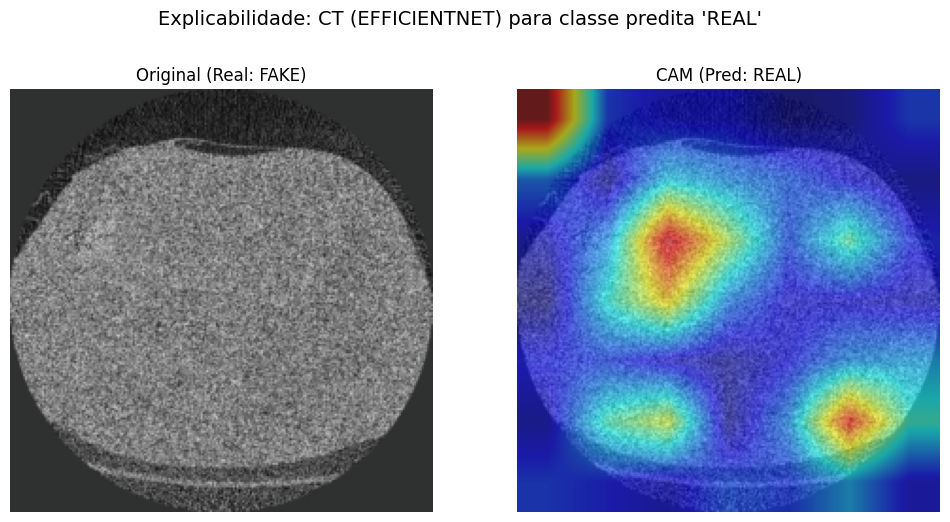


--- Carregado EFFICIENTNET / CT de: EfficientNet_CT_best_weights.pth ---

--- CT | Modelo: EFFICIENTNET | Classe Real: REAL ---
1. Classificação do Modelo: REAL (68.58%)
2. Classe Real da Imagem: REAL


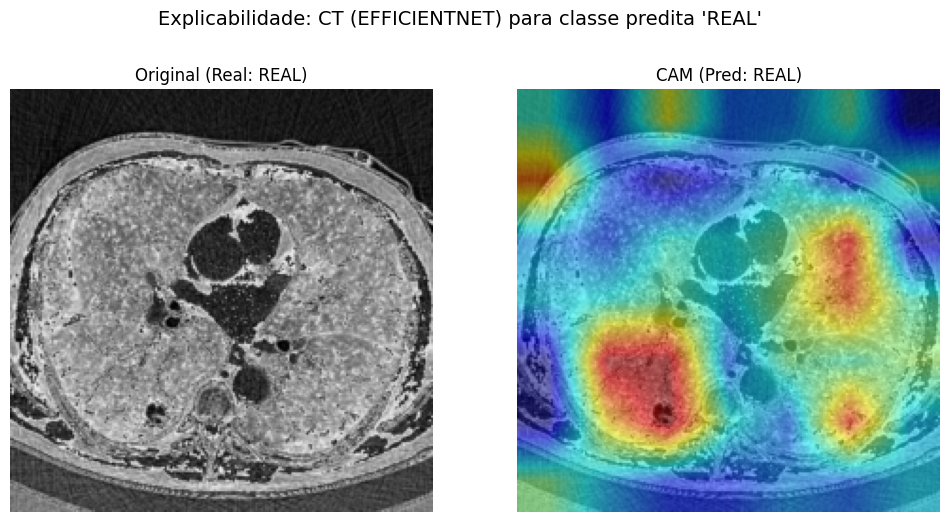


--- Carregado EFFICIENTNET / MRI de: EfficientNet_MRI_best_weights.pth ---

--- MRI | Modelo: EFFICIENTNET | Classe Real: FAKE ---
1. Classificação do Modelo: FAKE (99.43%)
2. Classe Real da Imagem: FAKE


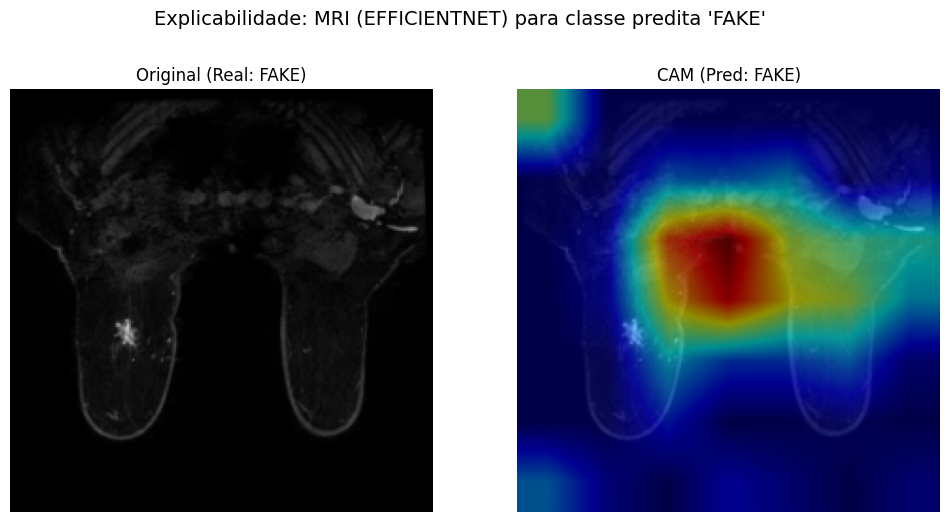


--- Carregado EFFICIENTNET / MRI de: EfficientNet_MRI_best_weights.pth ---

--- MRI | Modelo: EFFICIENTNET | Classe Real: REAL ---
1. Classificação do Modelo: REAL (90.67%)
2. Classe Real da Imagem: REAL


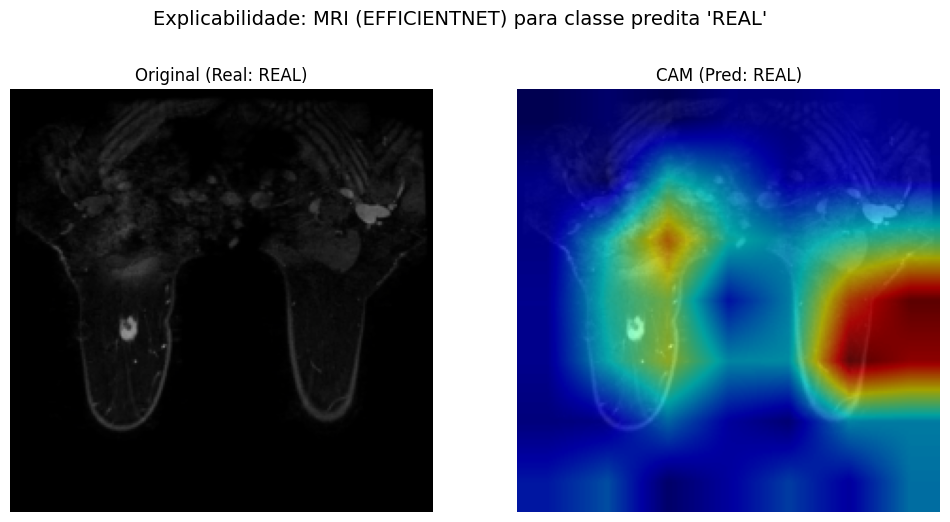


--- Carregado VIT / CT de: VisionTransformer_CT_best_weights.pth ---

--- CT | Modelo: VIT | Classe Real: FAKE ---
1. Classificação do Modelo: REAL (68.01%)
2. Classe Real da Imagem: FAKE


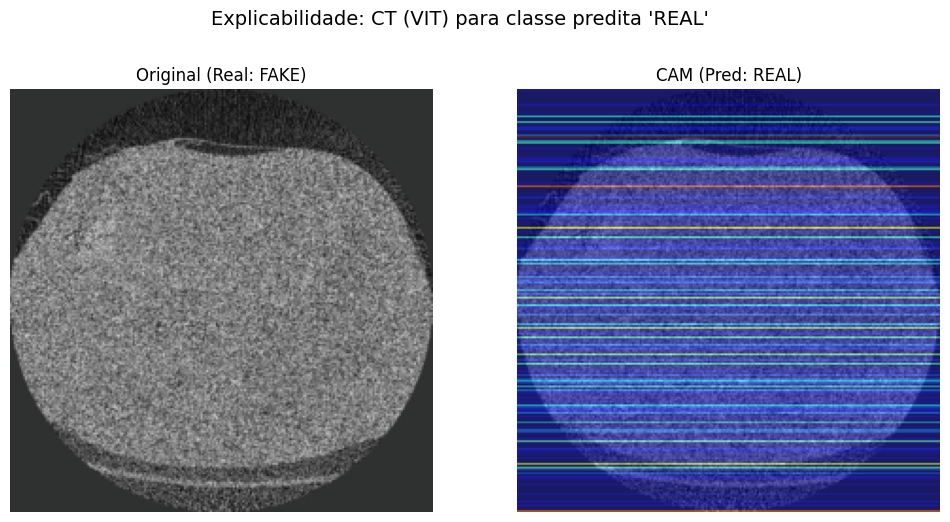


--- Carregado VIT / CT de: VisionTransformer_CT_best_weights.pth ---

--- CT | Modelo: VIT | Classe Real: REAL ---
1. Classificação do Modelo: REAL (70.52%)
2. Classe Real da Imagem: REAL


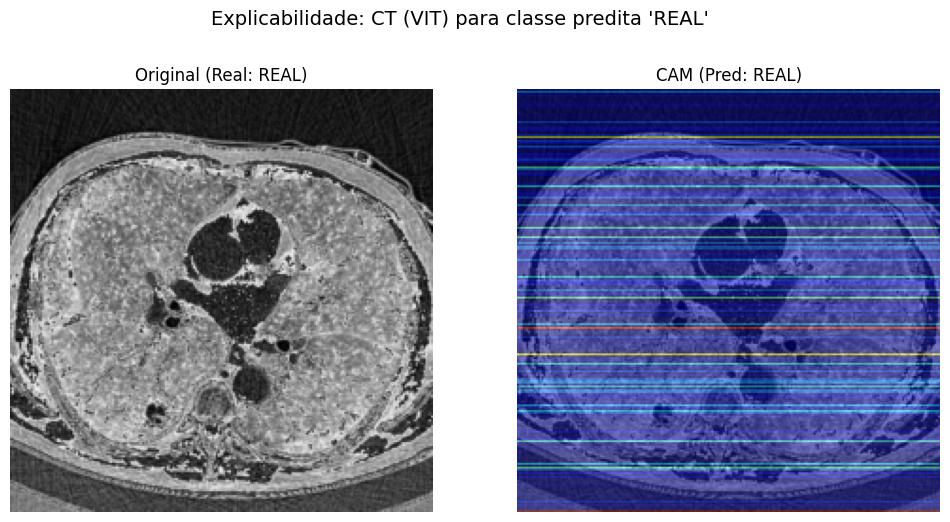


--- Carregado VIT / MRI de: VisionTransformer_MRI_best_weights.pth ---

--- MRI | Modelo: VIT | Classe Real: FAKE ---
1. Classificação do Modelo: FAKE (60.96%)
2. Classe Real da Imagem: FAKE


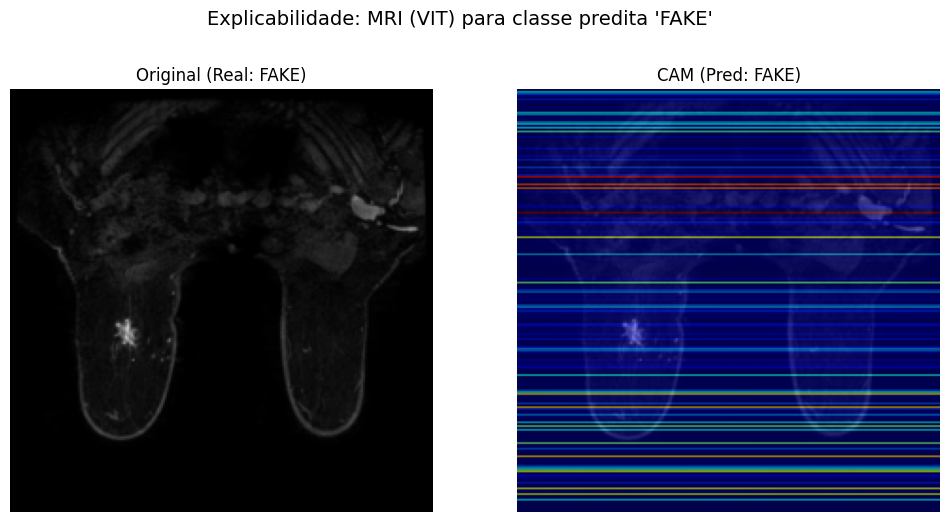


--- Carregado VIT / MRI de: VisionTransformer_MRI_best_weights.pth ---

--- MRI | Modelo: VIT | Classe Real: REAL ---
1. Classificação do Modelo: FAKE (60.95%)
2. Classe Real da Imagem: REAL


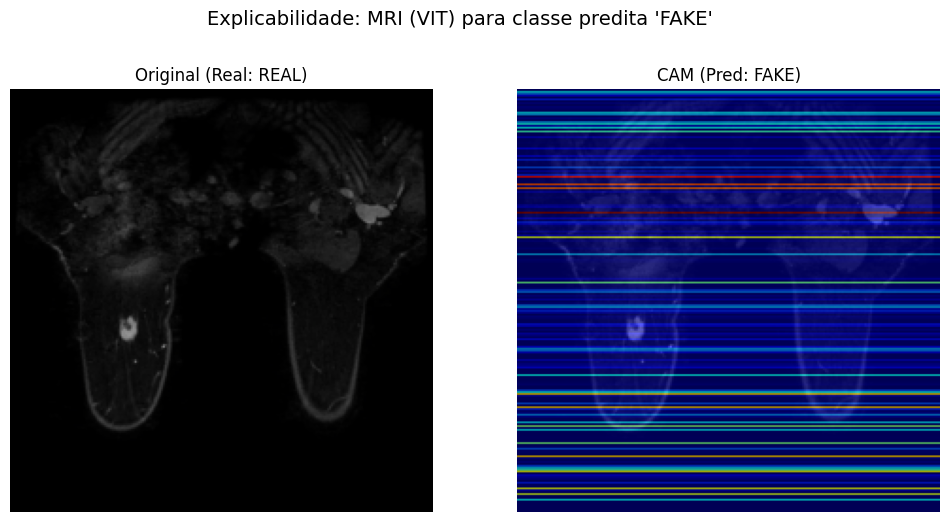

In [ ]:
# ================================================================
# 📌 FUNÇÃO AUXILIAR PARA CARREGAR MODELO E PEGAR IMAGEM DE TESTE
# ================================================================

def load_model_and_get_sample(model_type, dataset_type, dataloader, target_class):
    """Carrega o modelo salvo e encontra uma imagem de teste da classe alvo."""

    model_name = "efficientnet" if model_type == 'EFFICIENTNET' else "vit"

    # 1. Inicializa o modelo (estrutura)
    model = initialize_model(model_name, 2)
    model = model.to(DEVICE)

    # 2. Carrega os pesos salvos
    model_filename = f"{model.__class__.__name__}_{dataset_type}_best_weights.pth"
    try:
        model.load_state_dict(torch.load(model_filename, map_location=DEVICE))
        print(f"\n--- Carregado {model_type} / {dataset_type} de: {model_filename} ---")
    except FileNotFoundError:
        print(f"\n⚠️ ERRO: Arquivo de pesos {model_filename} não encontrado. Pulando.")
        return None, None

    # 3. Encontra uma imagem da classe alvo no DataLoader
    target_tensor = None

    for inputs, labels in dataloader:
        idx = (labels == target_class).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            # Pega a primeira imagem que corresponde à classe
            target_tensor = inputs[idx[0]].unsqueeze(0).to(DEVICE)
            break

    if target_tensor is None:
        print(f"⚠️ Aviso: Nenhuma imagem da classe {CLASS_NAMES[target_class]} encontrada no teste.")
        return None, None

    # 4. Define as camadas alvo para o CAM
    target_layers = get_target_layers(model_name, model)

    return model, target_layers, target_tensor


# ----------------------------------------------------
# 📌 EXECUÇÃO DA EXPLICABILIDADE
# ----------------------------------------------------

# Assumindo que você tem os dataloaders prontos:
# ct_test_loader = ct_dataloaders['test']
# mri_test_loader = mri_dataloaders['test']

# O código abaixo é um loop de execução. Você deve rodá-lo após garantir
# que os dataloaders e as funções auxiliares estejam carregados.

for model_type in ['EFFICIENTNET', 'VIT']:
    for dataset_type, test_loader in [('CT', ct_test_loader), ('MRI', mri_test_loader)]:

        # Define o método CAM (HiResCAM é bom para ViT)
        cam_method = HiResCAM if model_type == 'VIT' else GradCAM

        for target_class in [CLASS_TO_IDX['FAKE'], CLASS_TO_IDX['REAL']]:

            # 1. Carrega o modelo e a amostra
            model, target_layers, input_tensor = load_model_and_get_sample(
                model_type, dataset_type, test_loader, target_class
            )

            if model is None:
                continue

            # 2. Gera a Explicabilidade
            explain_image(
                model=model,
                target_layers=target_layers,
                input_tensor=input_tensor,
                target_label_id=target_class,
                dataset_name=dataset_type,
                model_name=model_type,
                method=cam_method
            )